In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat
import imp

# SMCNOD

This is data taken from AAT/AAO as part of the S5 collaboration (Ji et al. in prep).
We targeted a diffuse dwarf galaxy SMC and want to measure its velocity and metallicity dispersion.
We obtained multifiber spectroscopy of ~300 stars and used a pipeline to measure the radial velocities and metallicities, obtaining ~150 stars with good measurements.
Within the field of view, targets are selected based off of their color-magnitude diagrams and proper motions. This can still leave substantial contamination from disk or halo stars that can be separated using the stellar velocities and metallicities.

We will fit a Gaussian mixture model to this data using `emcee`.

In [3]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
c6 = np.sqrt(table_cut['pmra']**2 + table_cut['pmdec']**2) < 10
high_quality = (c1 | c2) & c3 & c4 & c6
table_cut = table_cut[high_quality]
tab = table_cut

In [4]:
len(tab)

291

In [5]:
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]

Text(0.5, 0, '[Fe/H]')

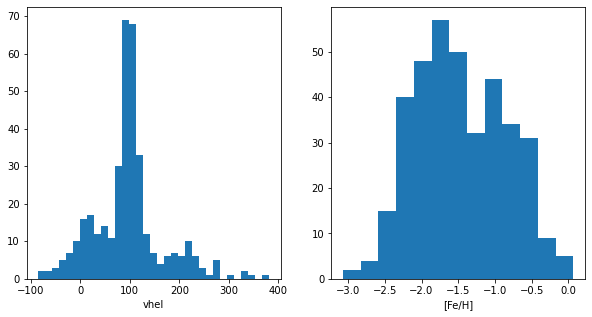

In [37]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].hist(rv, bins='auto');
axes[0].set_xlabel("vhel")
axes[1].hist(feh, bins='auto');
axes[1].set_xlabel("[Fe/H]")

By eye, there are 2-3 components. We will model these as a mixture of 3 gaussians. The parameters will be:

* pgal = fraction of stars in the galaxy
* pbg1 = fraction of stars in the 1st background component
* vhel = mean velocity of the galaxy in km/s
* lsigv = log10 the velocity dispersion of the galaxy in km/s
* feh = mean metallicity of the galaxy in dex
* lsigfeh = log10 the metallicity dispersion of the galaxy in dex
* vbg1, lsigvbg1, fehbg1, lsigfeh1 = same parameters for 1st background component
* vbg2, lsigvbg2, fehbg2, lsigfeh2 = same parameters for 2nd background component

In total there are 14 parameters.

# Likelihood function

In [23]:
param_labels = ["pgal","pbg1",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1",
                "vbg2","lsigvbg2","fehbg2","lsigfeh2"]
def lnprob(theta):
    """ Likelihood and Prior """
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2 = theta
    
    ## The prior is just a bunch of hard cutoffs
    if (pgal > 1) or (pgal < 0) or (pbg1 > 1) or (pbg1 < 0) or \
        (lsigv > 3) or (lsigvbg1 > 3) or (lsigvbg2 > 3) or \
        (lsigv < -1) or (lsigvbg1 < -1) or (lsigvbg2 < -1) or \
        (lsigfeh > 1) or (lsigfeh1 > 1) or (lsigfeh1 > 1) or \
        (lsigfeh < -3) or (lsigfeh1 < -3) or (lsigfeh1 < -3) or \
        (vhel > 400) or (vhel < -100) or (vbg1 > 500) or (vbg1 < 50) or \
        (vbg2 > 50) or (vbg2 < -50):
        return -1e10 # outside of prior, return a tiny number
    
    ## Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    
    ## Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh0,    scale=np.sqrt(feherr**2 + (10**lsigfeh)**2))
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    
    ## Note: If for some reason you have covariances, e.g. for Gaia proper motions, 
    ## you can use stats.multivariate_normal.logpdf
    
    ## Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_feh
    lbg1 = np.log(pbg1) + lbg1_vhel + lbg1_feh
    lbg2 = np.log(1-pbg1) + lbg2_vhel + lbg2_feh
    ## np.logaddexp takes the exp, adds them, and re-lns them in a numerically stable way
    lbgtot = np.logaddexp(lbg1, lbg2)
    ltot = np.logaddexp(lgal, np.log(1-pgal) + lbgtot)
    
    return np.sum(ltot)

def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))
def project_model(theta, rvmin=-200, rvmax=500, fehmin=-4, fehmax=1):
    """ Turn parameters into rv and feh distributions """
    params = get_paramdict(theta)
    rvarr = np.linspace(rvmin, rvmax, 1000)
    feharr = np.linspace(fehmin, fehmax, 1000)
    
    prv0 = params["pgal"]*stats.norm.pdf(rvarr, loc=params["vhel"], scale=10**params["lsigv"])
    prv1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(rvarr, loc=params["vbg1"], scale=10**params["lsigvbg1"])
    prv2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(rvarr, loc=params["vbg2"], scale=10**params["lsigvbg2"])
    
    pfe0 = params["pgal"]*stats.norm.pdf(feharr, loc=params["feh"], scale=10**params["lsigfeh"])
    pfe1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(feharr, loc=params["fehbg1"], scale=10**params["lsigfeh1"])
    pfe2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(feharr, loc=params["fehbg2"], scale=10**params["lsigfeh2"])
    return rvarr, prv0, prv1, prv2, feharr, pfe0, pfe1, pfe2

def plot_1d_distrs(theta):
    ## I'm being lazy and just using the global variables rv, rverr, feh, feherr.
    ## This makes life hard if you need to debug, but oops
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    model_output = project_model(theta)

    fig, axes = plt.subplots(1,2,figsize=(10,5))
    ax = axes[0]
    ax.hist(rv, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[0:4]
    ax.plot(xp, p0 + p1 + p2, 'k-', label="Total", lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="vhel (km/s)", ylabel="Prob. Density")
    ax.legend(fontsize='small')

    ax = axes[1]
    ax.hist(feh, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[4:8]
    ax.plot(xp, p0 + p1 + p2, 'k-', lw=3)
    ax.plot(xp, p2, ':', color=colors[2], lw=3)
    ax.plot(xp, p1, ':', color=colors[1], lw=3)
    ax.plot(xp, p0, ':', color=colors[0], lw=3)
    ax.set(xlabel="[Fe/H] (dex)", ylabel="Prob. Density")
    return fig
def plot_2d_distr(theta):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(feh, rv, 'k.')
    ax.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-100,400))
    
    params = get_paramdict(theta)
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    ax.errorbar(params["feh"], params["vhel"],
               xerr=2*10**params["lsigfeh"], yerr=2*10**params["lsigv"],
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg1"], params["vbg1"],
               xerr=2*10**params["lsigfeh1"], yerr=2*10**params["lsigvbg1"],
               color=colors[1], marker='x', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg2"], params["vbg2"],
               xerr=2*10**params["lsigfeh2"], yerr=2*10**params["lsigvbg2"],
               color=colors[2], marker='.', elinewidth=1, capsize=3, zorder=9999)

    ax.grid()

# Optimize parameters

In general, it's very inefficient to use MCMC to find the optimum values.
The point of using emcee is to propagate error bars.
So let's find something close to the best values with an optimization.

(0.0, 0.01)

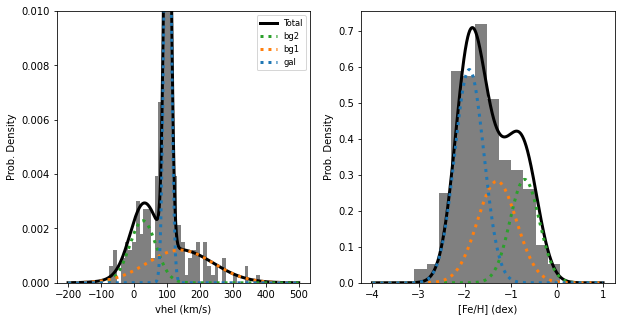

In [24]:
p0_guess = [0.47, 0.57,
            102, 1, -1.9,-0.5,
            140, 2.0, -1.3, -0.37,
            27, 1.6, -0.7, -0.5]

fig = plot_1d_distrs(p0_guess)
fig.axes[0].set_ylim(0,0.01)

In [25]:
## Define a temporary function that is the negative of the log likelihood
## This is because the scipy optimizers minimize instead of maximize
optfunc = lambda theta: -lnprob(theta)
%time result = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")
print(result.message)

CPU times: user 2.05 s, sys: 9.04 ms, total: 2.06 s
Wall time: 2.06 s
Maximum number of function evaluations has been exceeded.


In [26]:
## Print the result nicely
output = get_paramdict(result.x)
for label, value in output.items():
    print(label, value)
# sigma is intransit scattering

pgal 0.5544716092415387
pbg1 0.35409343997991793
vhel 98.64865871114628
lsigv 1.1066367374729333
feh -1.8616229690180819
lsigfeh -0.4834123708654545
vbg1 179.60062897748764
lsigvbg1 1.9191323944878982
fehbg1 -1.624821673641609
lsigfeh1 -0.31155502225093934
vbg2 40.77120740985832
lsigvbg2 1.7565522956654438
fehbg2 -0.861900500577095
lsigfeh2 -0.3843374124406881


It's always a good idea to project the parameters back into the observed space to see if it's doing a good job. This should be pretty close, otherwise emcee will never find your answer.
It's also a good way to debug your likelihood.

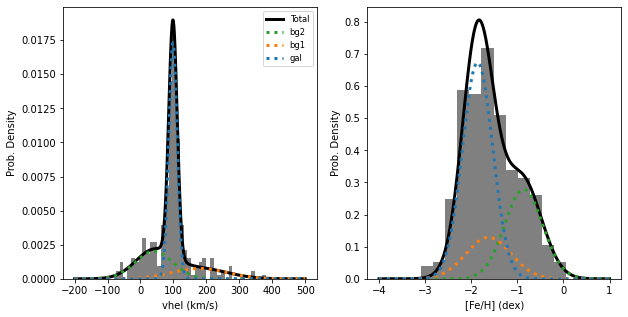

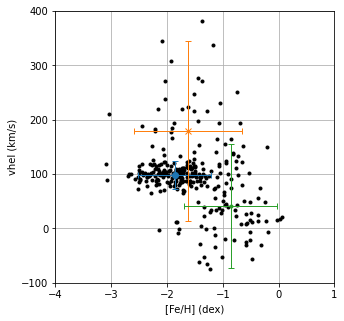

In [27]:
fig1 = plot_1d_distrs(result.x)
fig2 = plot_2d_distr(result.x)

# Run the sampler

In [28]:
nw = 64
p0 = result.x
nit = 2000
ep0 = np.zeros(len(p0_guess)) + 0.02
p0s = np.random.multivariate_normal(p0_guess, np.diag(ep0)**2, size=nw)
print(p0s)

[[  0.46956507   0.57757987 101.98151109   1.01876043  -1.88949758
   -0.52208897 140.02310593   2.00627984  -1.31291038  -0.35681001
   26.95283185   1.61099161  -0.7285494   -0.51237001]
 [  0.42136218   0.54380666 101.98110917   0.99857811  -1.91066059
   -0.4869234  139.99238305   1.98075322  -1.26950488  -0.40586757
   27.01464465   1.58229073  -0.71583754  -0.47324105]
 [  0.46402443   0.55594832 101.97849804   0.98936767  -1.94454694
   -0.49216064 140.01904475   2.04472921  -1.30867995  -0.41465782
   27.00601104   1.60516956  -0.67445028  -0.50604658]
 [  0.45747758   0.55933233 102.01756307   0.98920263  -1.86837302
   -0.5168354  140.02873414   1.99199918  -1.26939051  -0.39135848
   26.99878728   1.57421517  -0.69729521  -0.49067136]
 [  0.46537651   0.56032232 102.01632571   0.98629896  -1.84126706
   -0.54325031 140.00437473   2.01717248  -1.32732985  -0.35450469
   26.99848797   1.6141343   -0.67717787  -0.48928086]
 [  0.5009206    0.56949213 102.00092534   1.01042091  

In [29]:
nparams = len(param_labels)
print(nparams)
nwalkers = 64
p0 = p0_guess
ep0 = np.zeros(len(p0)) + 0.02 # some arbitrary width that's pretty close; scale accordingly to your expectation of the uncertainty
p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)
## Check to see things are initialized ok
lkhds = [lnprob(p0s[j]) for j in range(nwalkers)]
assert np.all(np.array(lkhds) > -9e9)

14


In [32]:
def get_rstate():
    return np.random.mtrand.RandomState(seed=np.random.randint(0,2**32-1))
from schwimmbad import MultiPool
pool = MultiPool(8)
es = emcee.EnsembleSampler(
    nw, len(p0_guess), lnprob)

In [33]:
%time PP = es.run_mcmc(p0s, nit, rstate0=get_rstate())
es.reset()

CPU times: user 1min 24s, sys: 377 ms, total: 1min 25s
Wall time: 1min 25s


In [34]:
%time es.run_mcmc(PP.coords, nit, rstate0=get_rstate())
np.save("SMCNOD_noPM_mcmc.npy",es.flatchain)

CPU times: user 1min 23s, sys: 764 ms, total: 1min 23s
Wall time: 1min 24s


In [36]:
chain = es.chain
chain.shape

(64, 2000, 14)

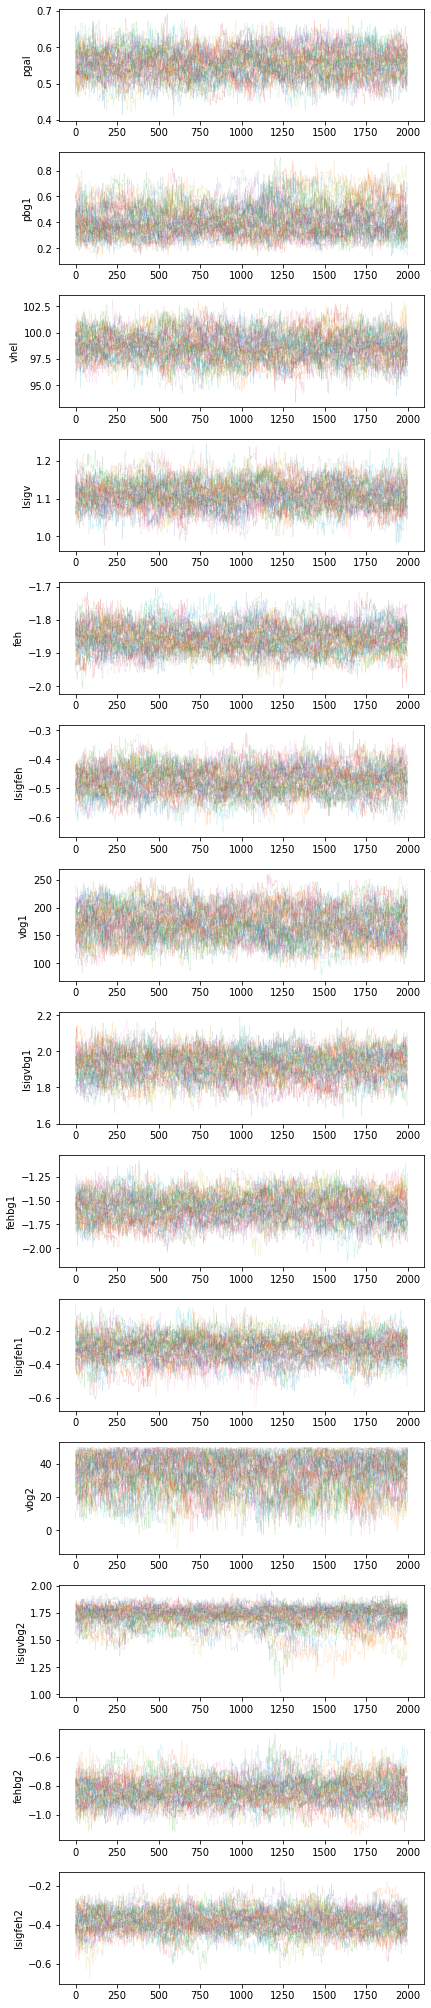

In [37]:
Nrow = chain.shape[2]
fig, axes = plt.subplots(Nrow, figsize=(6,2*Nrow))
for iparam,ax in enumerate(axes):
    for j in range(nwalkers):
        ax.plot(chain[j,:,iparam], lw=.5, alpha=.2)
        ax.set_ylabel(param_labels[iparam])
fig.tight_layout()

In [47]:
outputs = es.flatchain
outputs.shape

(128000, 14)

In [48]:
# check the mean acceptance fraction of the ensemble
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(es.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.337


You can see the output of the fit as a corner plot. Basically you want everything to be nice and round, and if not that means you didn't initialize your walkers well enough or burn in for long enough.

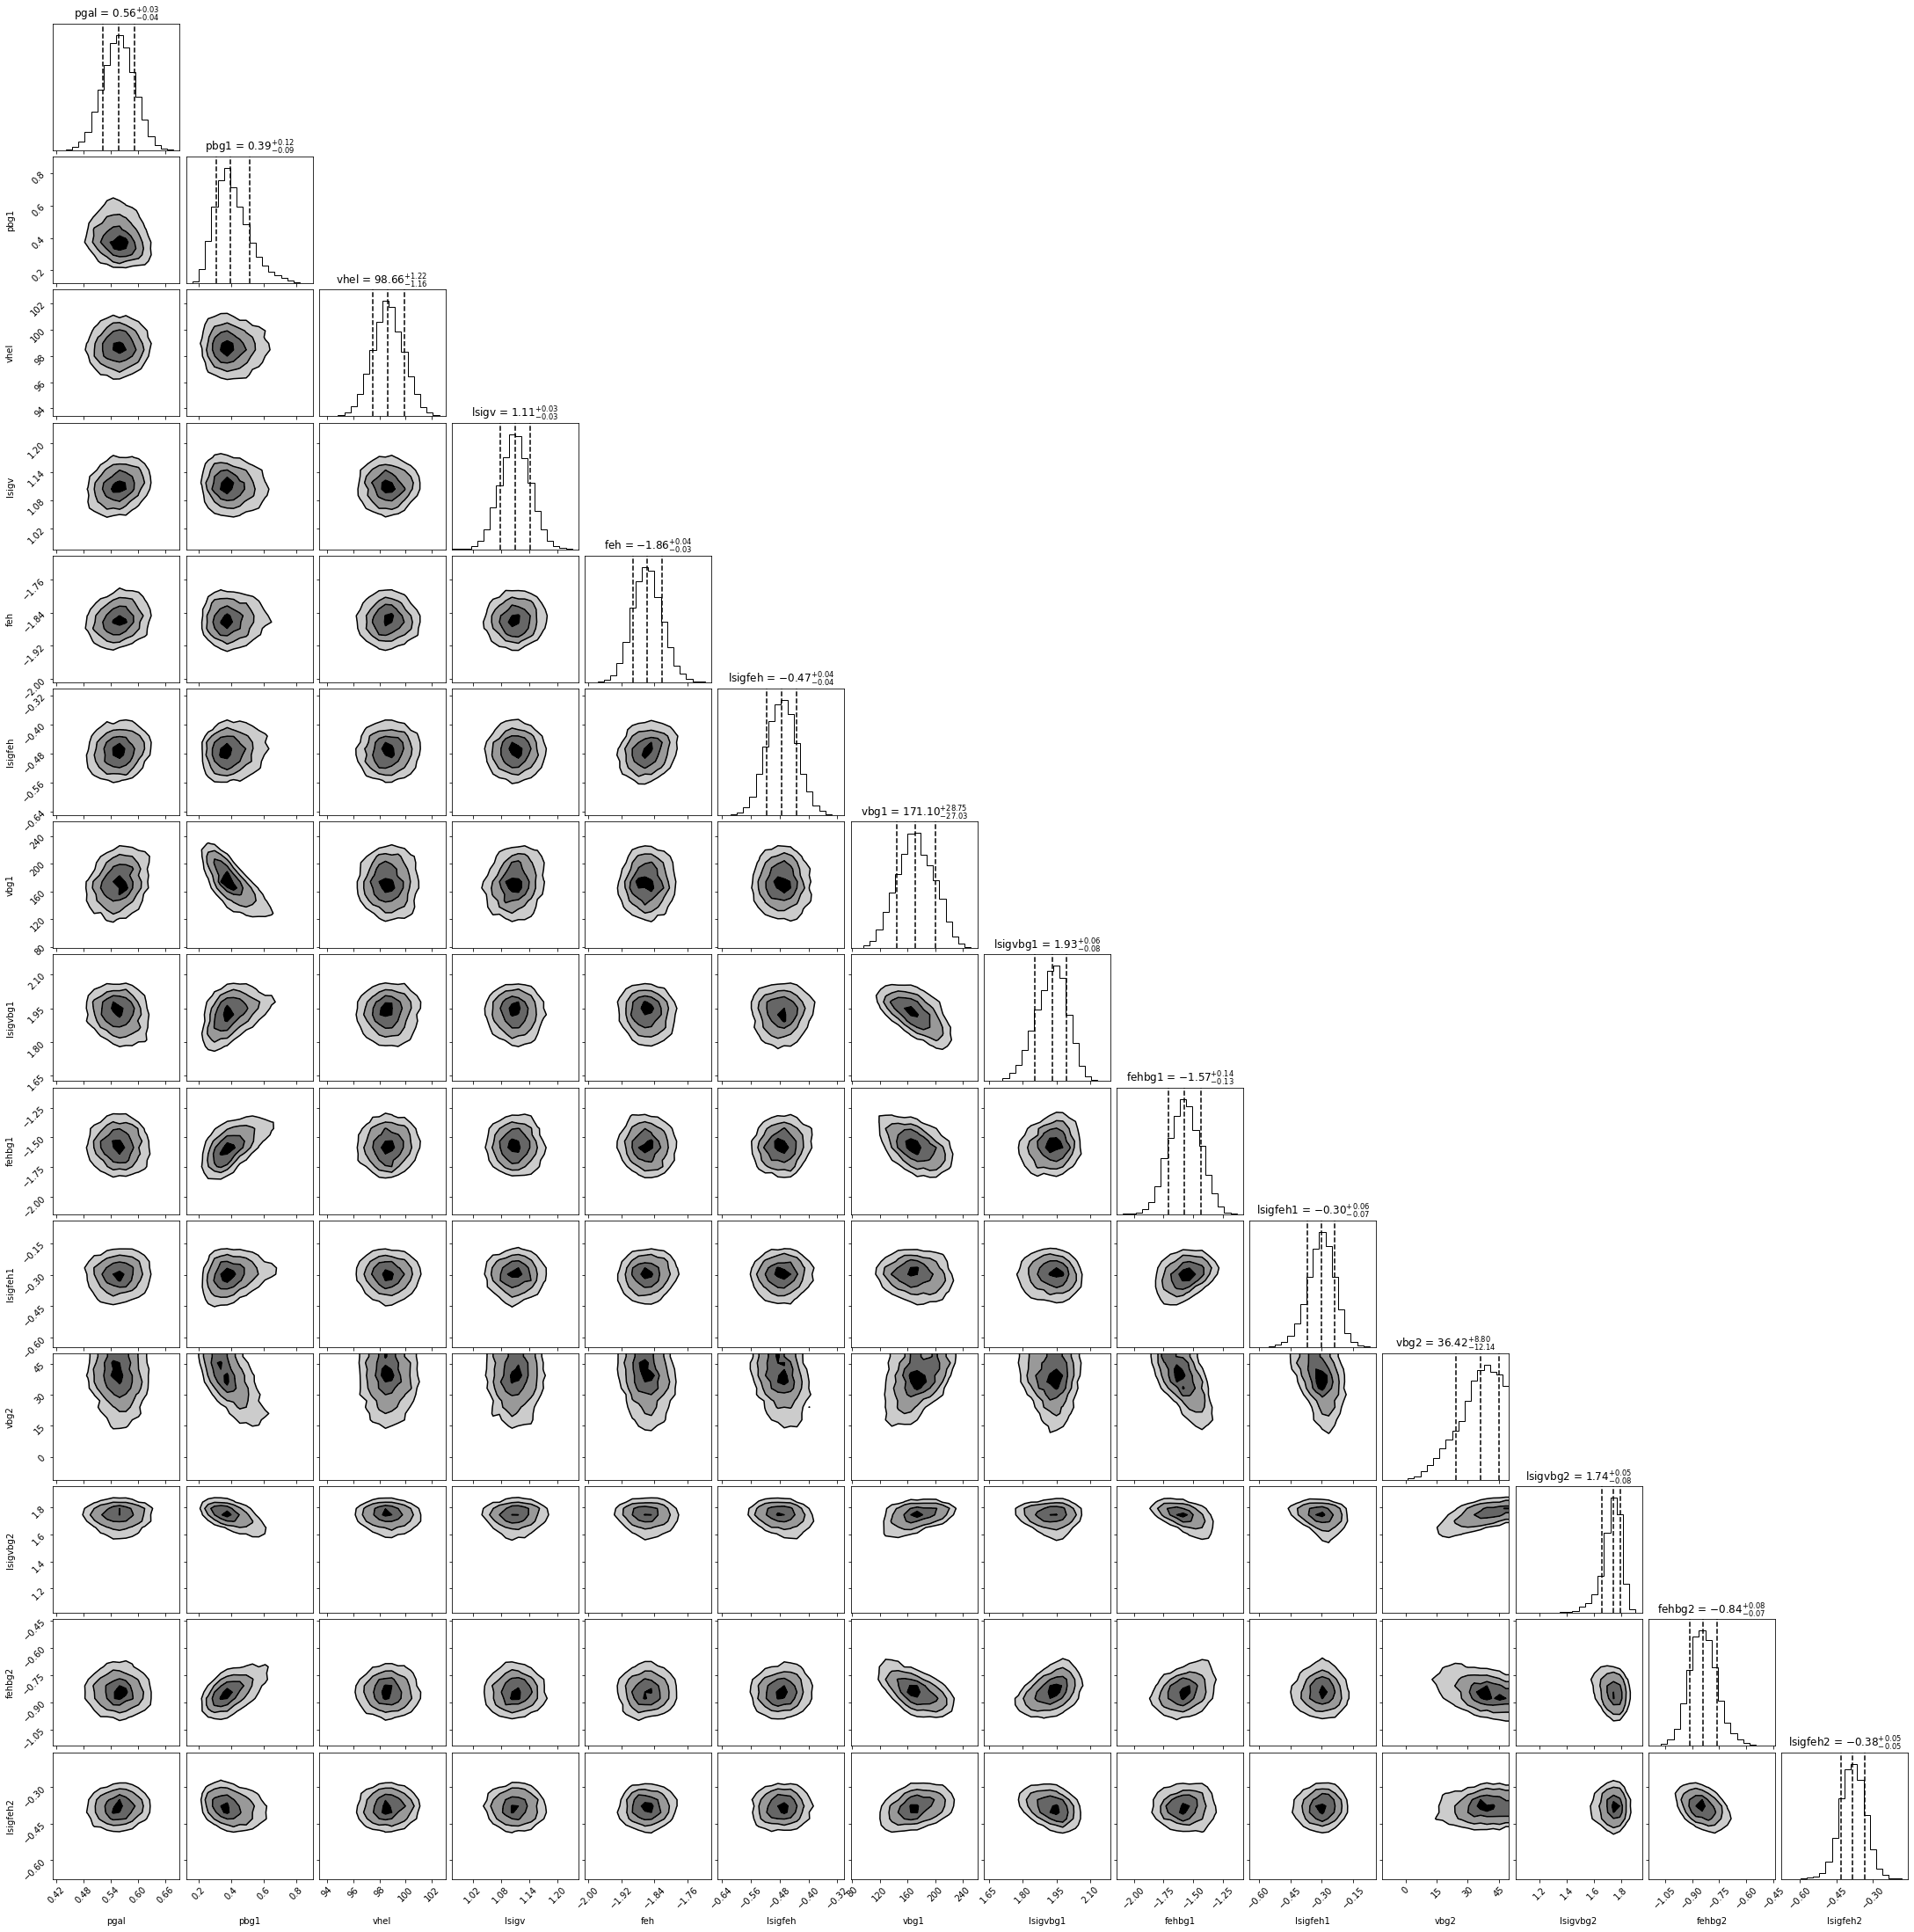

In [49]:
fig = corner.corner(outputs, labels=param_labels, quantiles=[0.16,0.50,0.84], show_titles=True,color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})
plt.savefig('SMCNOD_noPM_corner.png')

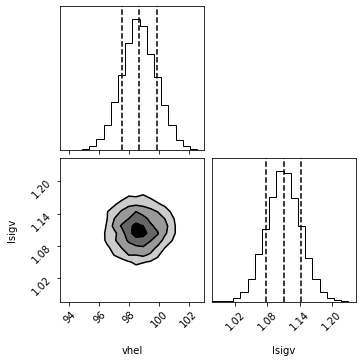

In [50]:
fig1 = corner.corner(outputs[:,2:4], labels=param_labels[2:4], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

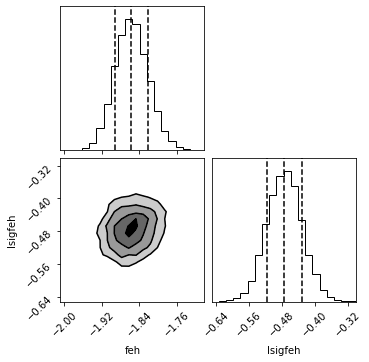

In [51]:
fig2 = corner.corner(outputs[:,4:6], labels=param_labels[4:6], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

In [52]:
def process_chain(outputs, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))

In [53]:
meds, errs = process_chain(outputs)

In [54]:
for k,v in meds.items():
    print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

pgal 0.557 0.035
pbg1 0.392 0.104
vhel 98.656 1.189
lsigv 1.110 0.032
feh -1.857 0.036
lsigfeh -0.474 0.042
vbg1 171.098 27.892
lsigvbg1 1.931 0.071
fehbg1 -1.574 0.135
lsigfeh1 -0.300 0.064
vbg2 36.422 10.470
lsigvbg2 1.741 0.067
fehbg2 -0.841 0.075
lsigfeh2 -0.383 0.050


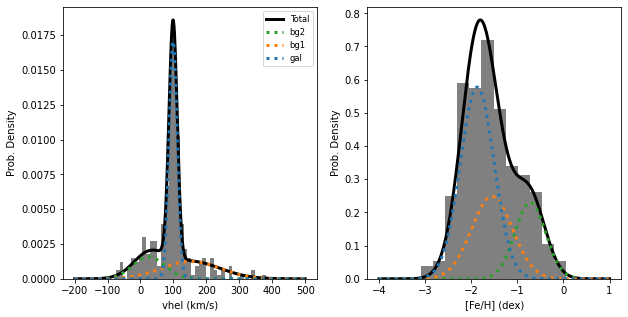

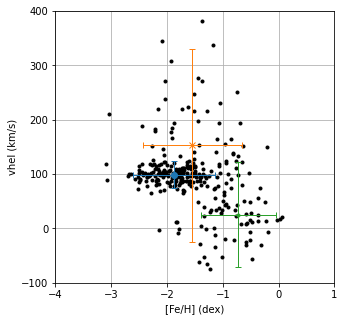

In [55]:
fig1 = plot_1d_distrs(chain[1])
fig2 = plot_2d_distr(chain[1])

In [56]:
chain_new = 10**chain

In [57]:
mean_vdisp = np.percentile(chain_new, 50)
mean_vdisp

3.305716262480729

In [58]:
chain_new = 10**chain
mean_vdisp = np.percentile(chain_new[:,3], 50)
std_vdisp = (np.percentile(chain_new[:,3], 84)-np.percentile(chain_new[:,3], 16))/2
mean_fehdisp = np.percentile(chain_new[:,5], 50)
std_fehdisp = (np.percentile(chain_new[:,5], 84)-np.percentile(chain_new[:,5], 16))/2
print("mean_vdisp: ",mean_vdisp, \
     "std_vdisp: ",std_vdisp)
print("mean_fehdisp: ",mean_fehdisp, \
     "std_fehdisp: ",std_fehdisp)

mean_vdisp:  12.881857494261986 std_vdisp:  0.9422065183909183
mean_fehdisp:  0.3357781280474302 std_fehdisp:  0.03262434044663573


In [59]:
# a stupid way to get parameters with '='
param_labels_1 = ["pgal = ","pbg1 = ",
                "vhel = ","lsigv = ","feh = ","lsigfeh = ",
                "vbg1 = ","lsigvbg1 = ","fehbg1 = ","lsigfeh1 = ",
                "vbg2 = ","lsigvbg2 = ","fehbg2 = ","lsigfeh2 = "]
def process_chain_1(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    median = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error:
        err = (ep-em)/2
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, err))
    else:
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, ep)), OrderedDict(zip(param_labels_1, em))

meds_1, errs_1 = process_chain_1(outputs)

for k,v in meds_1.items():
    print("{} {:.3f}".format(k, v))

pgal =  0.557
pbg1 =  0.392
vhel =  98.656
lsigv =  1.110
feh =  -1.857
lsigfeh =  -0.474
vbg1 =  171.098
lsigvbg1 =  1.931
fehbg1 =  -1.574
lsigfeh1 =  -0.300
vbg2 =  36.422
lsigvbg2 =  1.741
fehbg2 =  -0.841
lsigfeh2 =  -0.383
